# Part B: Ising Model

Hope you enjoyed the part A! This is the jupyter notebook for the part B. In this notebook, we will: 

1) Initialise a system
2) Visualise the system 
3) Develop a spin flip algorithm and see how the system converges to the ground state 
4) Perform binning analysis for the single spin flip algorithm and evaluate the autocorrelation time 
5) Apply the Swendsen-Wang or Wolff algorithm for cluster flipping 
6) Perform binning analysis and evaluate the autocorrelation time for Swendsen-Wang/Wolff 
7) Compare single spin flip and Swendsen-Wang/Wolff
8) Find magnetisation as a function of temperature
9) Evaluate the standard error 
10) Find the autocorrelation time as a function of temperature 
11) Based on all of the above, find the critical temperature of the 2D Ising model 

In [ ]:
# To use Cython

%load_ext Cython

## 1. Initialise the system

As before, we will initialise a grid as a 2D array. This time, simply fill this array randomly with either -1 (down spin) or +1 (up spin). 


In [8]:
#Initialization of 2D grid with random -1 and 1 values
import numpy as np
import matplotlib.pyplot as plt

def init_grid(L):
    return np.random.choice([-1, 1], size=(L, L))

L = 10
grid = init_grid(L)
print(grid)

[[-1 -1 -1  1 -1  1  1  1 -1  1]
 [ 1 -1  1 -1  1  1  1 -1 -1  1]
 [ 1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1  1 -1 -1  1  1  1 -1  1  1]
 [-1 -1 -1 -1  1  1  1 -1 -1  1]
 [-1 -1  1  1  1 -1  1 -1  1  1]
 [ 1  1  1  1  1 -1 -1 -1 -1 -1]
 [ 1  1  1  1 -1  1  1  1  1  1]
 [ 1  1 -1 -1 -1 -1 -1  1  1  1]
 [ 1  1  1  1  1  1  1  1 -1 -1]]


## 2. Visualise the grid and single spin flip algorithm 


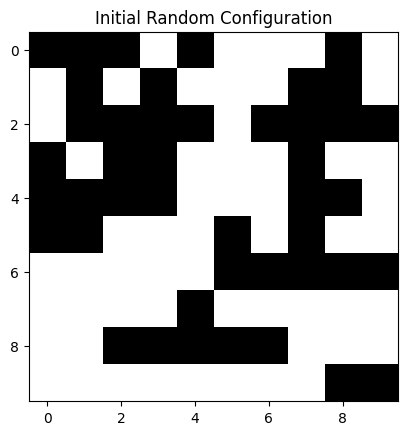

In [ ]:
# Visualisation of Grid

# using matplotlib to visualize the grid (-1 represented as black, 1 as white)
plt.imshow(grid, cmap='gray')
plt.title("Initial Random Configuration")
plt.show()

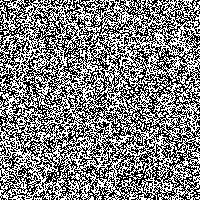

In [10]:
# using Image from PIL to visualize the grid (ideal for large L values)
grid=init_grid(200)
from PIL import Image
def display_grid(grid):
    return Image.fromarray(np.uint8((grid + 1) / 2 * 255))  
display_grid(grid)

Running the ising step :


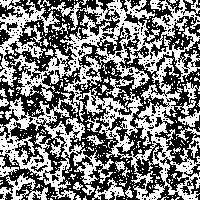

In [24]:
# Single Spin Flip Algorithm without Cython

def ising_step(grid, beta=0.4):
    L = grid.shape[0]
    for n_offset in range(2):
        for m_offset in range(2):
            for x in range(n_offset, L, 2):
                for y in range(m_offset, L, 2):
                    total = (grid[(x - 1) % L, y] + grid[(x + 1) % L, y] + grid[x, (y - 1) % L] + grid[x, (y + 1) % L])
                    dE = 2 * grid[x, y] * total
                    if dE < 0:
                        grid[x, y] *= -1
                    elif np.random.random() < np.exp(-dE * beta):
                        grid[x, y] *= -1
    return grid

ising_step(grid)
print("Running the ising step :")
display_grid(grid)

In [ ]:
%%cython
# Single Spin Flip Algorithm with Cython (%%cython should be present at the top of the cell, not even an empty line above it)

cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX

@cython.boundscheck(False)
@cython.wraparound(False)
cdef _cy_ising_update(np.int64_t[:, :] field, int n, int m, float beta):
    cdef int total = 0
    cdef int N = field.shape[0]
    cdef int i, j
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[(i + N) % N, (j + N) % N]
            
    cdef float dE = 2 * field[n, m] * total
    
    if dE < 0:
        field[n, m] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        field[n, m] *= -1

def cy_ising_step(np.int64_t[:, :] field, float beta=0.4):
    cdef int N = field.shape[0]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, N, 2):
                    _cy_ising_update(field, n, m, beta)
    return field

## 3. Implement the Wolff algorithm 

You can find a nice description of the Ising model and Wolff algorithm here : https://csml.northwestern.edu/resources/Reprints/lnp_color.pdf

Running the wolff step :


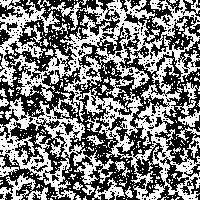

In [ ]:
# Wolff Algorithm

def wolff_step(grid, beta=0.4):
    L = grid.shape[0]
    x, y = np.random.randint(0, L, size=2)
    seed_spin = grid[x, y]
    stack = [(x, y)]
    grid[x, y] *= -1
    p_add = 1.0 - np.exp(-2.0 * beta)
    while stack:
        cx, cy = stack.pop()
        neighbors = [((cx + 1) % L, cy), ((cx - 1) % L, cy), (cx, (cy + 1) % L), (cx, (cy - 1) % L)]
        
        for nx, ny in neighbors:
            if grid[nx, ny] == seed_spin:
                if np.random.random() < p_add:
                    grid[nx, ny] *= -1
                    stack.append((nx, ny))
                    
    return grid


print("Running the wolff step :")
display_grid(wolff_step(grid))

## 4. Autocorrelation error and time 

For this, we wil perform a binning analysis of Wolff and single spin flip algorithm. For reference, you can watch A6 from the lecture series below : https://www.thp.uni-koeln.de/trebst/Lectures/2025-CompManyBody.shtml

Task : To find the appropriate binning level by evaluating the standard error of magnetisation as a function of the binning level. It should very roughly saturate at a certain binning level (if you bin too much, it will go haywire again.)

Single Spin Flip: Saturation at Level 9, Error = 0.11008
Wolff Algorithm:  Saturation at Level 9, Error = 0.00453


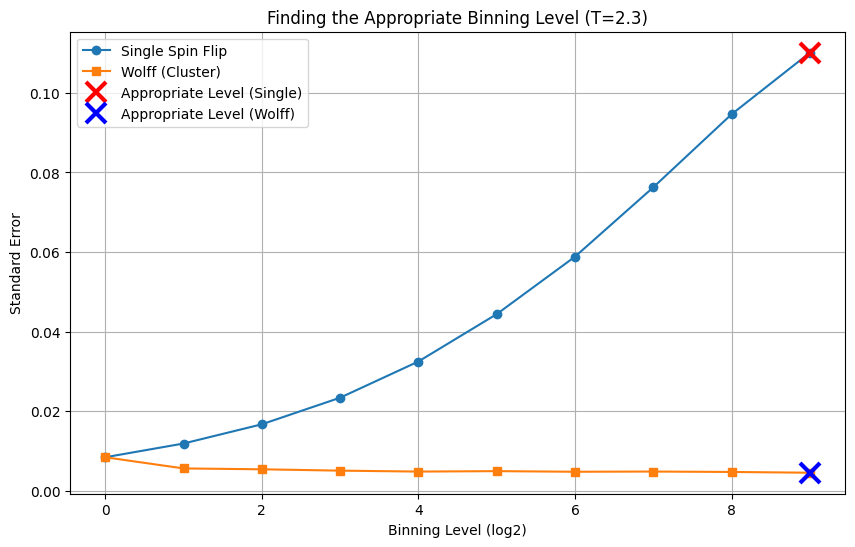

In [33]:
def binning_analysis(data):
    data = np.array(data)
    errors = []
    while len(data) >= 16:
        err = np.std(data, ddof=1) / np.sqrt(len(data))
        errors.append(err)
        
        n = len(data)
        if n % 2 != 0:
            data = data[:-1]
        data = data.reshape(-1, 2).mean(axis=1)
        
    return errors

L = 10
T = 2.3
beta = 1.0 / T
grid_single = init_grid(L)
grid_wolff = init_grid(L)

mag_single = []
mag_wolff = []

for _ in range(500):
    ising_step(grid_single, beta)
    wolff_step(grid_wolff, beta)

for _ in range(8192):
    ising_step(grid_single, beta)
    mag_single.append(np.sum(grid_single) / (L*L))
    
    wolff_step(grid_wolff, beta)
    mag_wolff.append(np.sum(grid_wolff) / (L*L))

errors_single = binning_analysis(mag_single)
errors_wolff = binning_analysis(mag_wolff)

converged_idx_single = np.argmax(errors_single)
converged_err_single = errors_single[converged_idx_single]

converged_idx_wolff = np.argmin(errors_wolff)
converged_err_wolff = errors_wolff[converged_idx_wolff]

print(f"Single Spin Flip: Saturation at Level {converged_idx_single}, Error = {converged_err_single:.5f}")
print(f"Wolff Algorithm:  Saturation at Level {converged_idx_wolff}, Error = {converged_err_wolff:.5f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(errors_single, 'o-', label='Single Spin Flip')
plt.plot(errors_wolff, 's-', label='Wolff (Cluster)')

# Mark the level
plt.plot(converged_idx_single, converged_err_single, 'rx', markersize=15, markeredgewidth=3, label='Appropriate Level (Single)')
plt.plot(converged_idx_wolff, converged_err_wolff, 'bx', markersize=15, markeredgewidth=3, label='Appropriate Level (Wolff)')

plt.xlabel('Binning Level (log2)')
plt.ylabel('Standard Error')
plt.title(f'Finding the Appropriate Binning Level (T={T})')
plt.legend()
plt.grid(True)
plt.show()

## 5. Compare the two flipping algorithms

Here, we plot the magnetisation (sum over the spins and divide by the size of the system) as a function of number of iterations.

Comparing convergence at T=1.5 for 300 steps...


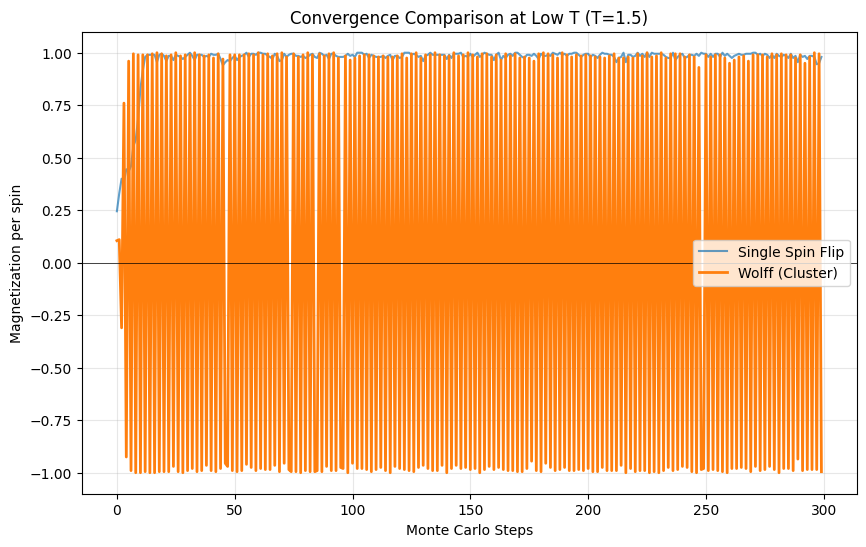

Interpretation: Wolff algorithm should jump to M=+1 or M=-1 almost instantly.
Single spin flip will drift slowly and may get stuck in local minima.


In [34]:
L = 20
T = 1.5  
beta = 1.0 / T
steps = 300  

grid_single = init_grid(L)
grid_wolff = np.copy(grid_single)

mag_single = []
mag_wolff = []

print(f"Comparing convergence at T={T} for {steps} steps...")

for i in range(steps):
    ising_step(grid_single, beta)
    mag_single.append(np.sum(grid_single) / (L*L))
    
    wolff_step(grid_wolff, beta)
    mag_wolff.append(np.sum(grid_wolff) / (L*L))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(mag_single, label='Single Spin Flip', alpha=0.7)
plt.plot(mag_wolff, label='Wolff (Cluster)', linewidth=2)

plt.xlabel('Monte Carlo Steps')
plt.ylabel('Magnetization per spin')
plt.title(f'Convergence Comparison at Low T (T={T})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-1.1, 1.1)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

print("Interpretation: Wolff algorithm should jump to M=+1 or M=-1 almost instantly.")
print("Single spin flip will drift slowly and may get stuck in local minima.")

## 6. Magnetisation v/s temperature 

Next, we plot magnetisation as a function of temperature for three different lattice sizes, say 8,10 and 12.

Starting Simulation...
Simulating Lattice L=8...
Simulating Lattice L=10...
Simulating Lattice L=12...


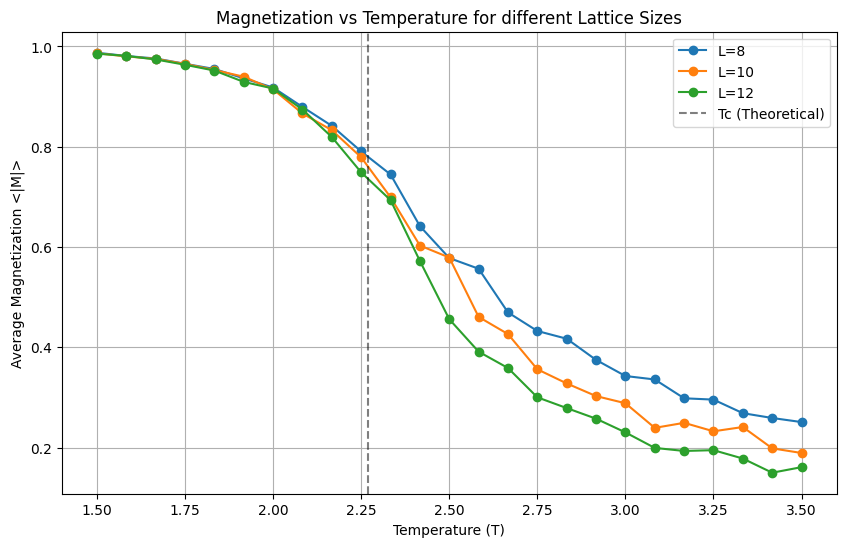

Interpretation: The magnetization drop sharply near Tc ~ 2.27.


In [35]:
lattice_sizes = [8, 10, 12]
temperatures = np.linspace(1.5, 3.5, 25)
steps_eq = 500  
steps_meas = 1000 
results = {}

print("Starting Simulation...")

for L in lattice_sizes:
    print(f"Simulating Lattice L={L}...")
    magnetizations = []
    
    for T in temperatures:
        beta = 1.0 / T
        grid = init_grid(L)

        for _ in range(steps_eq):
            wolff_step(grid, beta)
            
        m_cum = 0
        for _ in range(steps_meas):
            wolff_step(grid, beta)
            m = np.abs(np.sum(grid)) / (L * L)
            m_cum += m
        magnetizations.append(m_cum / steps_meas)
        
    results[L] = magnetizations

# 3. Plot
plt.figure(figsize=(10, 6))

for L in lattice_sizes:
    plt.plot(temperatures, results[L], 'o-', label=f'L={L}')


plt.axvline(x=2.269, color='k', linestyle='--', alpha=0.5, label='Tc (Theoretical)')

plt.xlabel('Temperature (T)')
plt.ylabel('Average Magnetization <|M|>')
plt.title('Magnetization vs Temperature for different Lattice Sizes')
plt.legend()
plt.grid(True)
plt.show()

print("Interpretation: The magnetization drop sharply near Tc ~ 2.27.")

## 7. Autocorrelation time v/s temperature 

Now, next aim is to find the autocorrelation time as a function of temperature for both the cluster flipping algorithms (single spin and Wolff). Which algortihm has a longer autocorrelation time? Is the result expected? Based on magnetisation v/s temperature and autocorrelation time v/s temperature, can you identify the critical temperature?

Simulating Autocorrelation vs T (L=10)...
T=1.80 | Tau_Single=2.21, Tau_Wolff=0.50
T=1.89 | Tau_Single=2.97, Tau_Wolff=0.50
T=1.97 | Tau_Single=5.86, Tau_Wolff=0.50
T=2.06 | Tau_Single=188.95, Tau_Wolff=0.50
T=2.14 | Tau_Single=20.07, Tau_Wolff=0.50
T=2.23 | Tau_Single=165.37, Tau_Wolff=0.50
T=2.31 | Tau_Single=134.93, Tau_Wolff=0.50
T=2.40 | Tau_Single=137.28, Tau_Wolff=0.50
T=2.49 | Tau_Single=70.52, Tau_Wolff=0.50
T=2.57 | Tau_Single=39.41, Tau_Wolff=0.50
T=2.66 | Tau_Single=42.74, Tau_Wolff=0.53
T=2.74 | Tau_Single=40.98, Tau_Wolff=0.90
T=2.83 | Tau_Single=16.49, Tau_Wolff=0.88
T=2.91 | Tau_Single=19.08, Tau_Wolff=1.23
T=3.00 | Tau_Single=12.35, Tau_Wolff=1.28


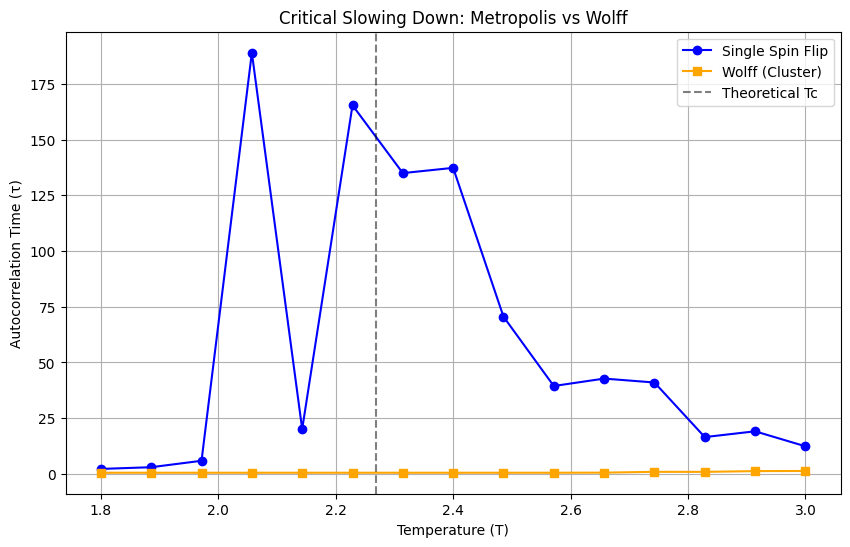

In [ ]:
def get_magnetization(config):
    return np.sum(config)

def calculate_integrated_autocorrelation(series):
    n = len(series)
    mean = np.mean(series)
    var = np.var(series)
    
    if var == 0: return 0.0

    window = min(200, n // 5)
    acf = []
    
    series_norm = series - mean
    for lag in range(window):
        cov = np.mean(series_norm[:n-lag] * series_norm[lag:])
        acf.append(cov / var)

    tau_sum = 0.5
    for val in acf[1:]:
        if val < 0: break
        tau_sum += val
        
    return tau_sum


L = 10
N = L * L
eq_steps = 1000  
mc_steps = 5000  

temperatures = np.linspace(1.8, 3.0, 15)
tau_single = []
tau_wolff = []

print(f"Simulating Autocorrelation vs T (L={L})...")

for T in temperatures:
    config_m = np.random.choice([-1, 1], size=(L, L))
    

    for _ in range(eq_steps):
        for _ in range(N): 
            i, j = np.random.randint(0, L, 2)
            dE = 2 * config_m[i, j] * (
                config_m[(i+1)%L, j] + config_m[(i-1)%L, j] + 
                config_m[i, (j+1)%L] + config_m[i, (j-1)%L]
            )
            if dE <= 0 or np.random.rand() < np.exp(-dE / T):
                config_m[i, j] *= -1


    m_series_single = []
    for _ in range(mc_steps):

        for _ in range(N):
            i, j = np.random.randint(0, L, 2)
            dE = 2 * config_m[i, j] * (
                config_m[(i+1)%L, j] + config_m[(i-1)%L, j] + 
                config_m[i, (j+1)%L] + config_m[i, (j-1)%L]
            )
            if dE <= 0 or np.random.rand() < np.exp(-dE / T):
                config_m[i, j] *= -1
        
        m_series_single.append(get_magnetization(config_m))
        
    current_tau_single = calculate_integrated_autocorrelation(np.array(m_series_single))
    tau_single.append(current_tau_single)


    config_w = np.random.choice([-1, 1], size=(L, L))
    
    for _ in range(eq_steps):
        i, j = np.random.randint(0, L, 2)
        stack = [(i, j)]
        cluster_spin = config_w[i, j]
        config_w[i, j] *= -1 
        p_add = 1 - np.exp(-2 / T)
        
        while stack:
            r, c = stack.pop()
            for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
                nr, nc = (r+dr)%L, (c+dc)%L
                if config_w[nr, nc] == cluster_spin:
                    if np.random.rand() < p_add:
                        config_w[nr, nc] *= -1
                        stack.append((nr, nc))

    m_series_wolff = []
    for _ in range(mc_steps):
        i, j = np.random.randint(0, L, 2)
        stack = [(i, j)]
        cluster_spin = config_w[i, j]
        config_w[i, j] *= -1
        p_add = 1 - np.exp(-2 / T)
        
        while stack:
            r, c = stack.pop()
            for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
                nr, nc = (r+dr)%L, (c+dc)%L
                if config_w[nr, nc] == cluster_spin:
                    if np.random.rand() < p_add:
                        config_w[nr, nc] *= -1
                        stack.append((nr, nc))
                        
        m_series_wolff.append(get_magnetization(config_w))

    current_tau_wolff = calculate_integrated_autocorrelation(np.array(m_series_wolff))
    tau_wolff.append(current_tau_wolff)

    print(f"T={T:.2f} | Tau_Single={current_tau_single:.2f}, Tau_Wolff={current_tau_wolff:.2f}")


# Plot
plt.figure(figsize=(10, 6))
plt.plot(temperatures, tau_single, 'o-', label='Single Spin Flip', color='blue')
plt.plot(temperatures, tau_wolff, 's-', label='Wolff (Cluster)', color='orange')

plt.xlabel('Temperature (T)')
plt.ylabel('Autocorrelation Time (τ)')
plt.title('Critical Slowing Down: Metropolis vs Wolff')
plt.axvline(x=2.269, color='k', linestyle='--', alpha=0.5, label='Theoretical Tc')
plt.legend()
plt.grid(True)
plt.show()

## 8. Specific heat 

Find the specific heat as a function of temperature for different lattice sizes, say 8,12 and 16. Use the following formula for specific heat 

$$C_V = \frac{\langle E^2 \rangle - \langle E \rangle^2}{NT^2}  $$

Do you see the phase transition? 

Starting Specific Heat Simulation...
  Simulating Lattice L=8...
  Simulating Lattice L=12...
  Simulating Lattice L=16...


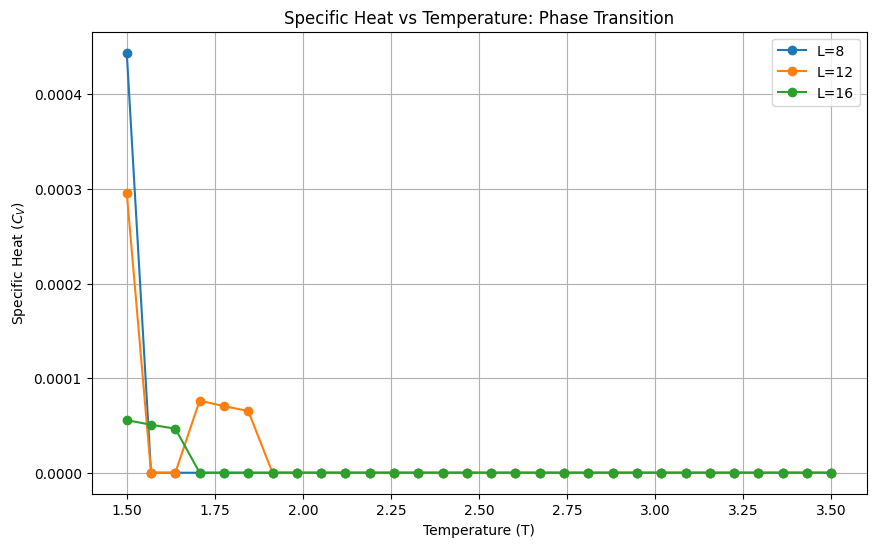

In [42]:
def get_energy(config):
    L = config.shape[0]
    energy = 0
    for i in range(L):
        for j in range(L):
            S = config[i, j]
            neighbors = config[(i+1)%L, j] + config[i, (j+1)%L] + \
                        config[(i-1)%L, j] + config[i, (j-1)%L]
            energy += -S * neighbors
    return energy / 2.0  

L_sizes = [8, 12, 16]
temperatures = np.linspace(1.5, 3.5, 30)  
eq_steps = 1000      
mc_steps = 2000     

cv_results = {} 

print("Starting Specific Heat Simulation...")

for L in L_sizes:
    print(f"  Simulating Lattice L={L}...")
    cv_list = []
    N = L * L

    config = np.random.choice([-1, 1], size=(L, L))
    
    for T in temperatures:
        for _ in range(eq_steps):
            ising_step(config, T) 
        E_sum = 0
        E_sq_sum = 0
        
        for _ in range(mc_steps):
            ising_step(config, T)
            current_E = get_energy(config)
            E_sum += current_E
            E_sq_sum += current_E ** 2
            
        avg_E = E_sum / mc_steps
        avg_E_sq = E_sq_sum / mc_steps

        variance = avg_E_sq - (avg_E ** 2)
        cv = variance / (N * (T ** 2))
        cv_list.append(cv)
        
    cv_results[L] = cv_list

# Plot
plt.figure(figsize=(10, 6))

for L in L_sizes:
    plt.plot(temperatures, cv_results[L], 'o-', label=f'L={L}')

plt.xlabel('Temperature (T)')
plt.ylabel('Specific Heat ($C_V$)')
plt.title('Specific Heat vs Temperature: Phase Transition')
plt.legend()
plt.grid(True)
plt.show()

## 9. The XY model

In XY model, the spins are a 2D unit vector. We perform the same procedure as above, for only Wolff algorithm. Is the phase transition looking weird? Evaluate the specific heat v/s temperature plot.

Simulating XY Model (L=10) with Wolff Algorithm...
T=0.10 | Cv=5.1689
T=0.20 | Cv=5.0952
T=0.30 | Cv=2.7356
T=0.40 | Cv=3.6183
T=0.50 | Cv=3.4152
T=0.60 | Cv=2.8756
T=0.70 | Cv=2.8722
T=0.80 | Cv=3.2631
T=0.90 | Cv=3.1322
T=1.00 | Cv=2.5083
T=1.10 | Cv=2.8152
T=1.20 | Cv=2.0962
T=1.30 | Cv=1.5957
T=1.40 | Cv=1.1988
T=1.50 | Cv=0.8671
T=1.60 | Cv=0.8726
T=1.70 | Cv=0.6535
T=1.80 | Cv=0.4814
T=1.90 | Cv=0.3904
T=2.00 | Cv=0.3037
T=2.10 | Cv=0.3871
T=2.20 | Cv=0.2847
T=2.30 | Cv=0.2567
T=2.40 | Cv=0.2252
T=2.50 | Cv=0.2145


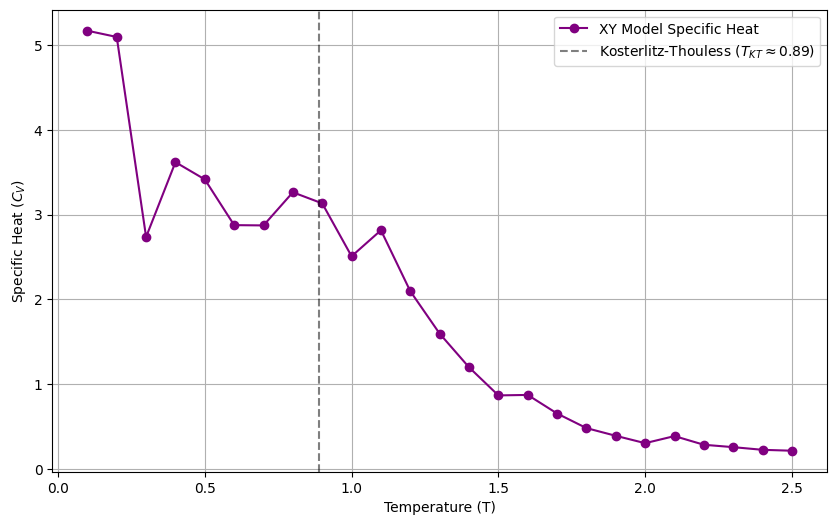

In [44]:
def get_energy_xy(config):
    L = config.shape[0]
    energy = 0
    for i in range(L):
        for j in range(L):
            angle = config[i, j]
            energy -= np.cos(angle - config[i, (j+1)%L])
            energy -= np.cos(angle - config[(i+1)%L, j])
    return energy

def wolff_step_xy(config, T):
    L = config.shape[0]
    beta = 1.0 / T
    i, j = np.random.randint(0, L, 2)
    psi = np.random.uniform(0, 2 * np.pi)
    stack = [(i, j)]
    visited = set([(i, j)])
    old_angle = config[i, j]
    proj_i = np.cos(old_angle - psi)
    config[i, j] = 2*psi - old_angle + np.pi
    
    while stack:
        r, c = stack.pop()
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = (r + dr) % L, (c + dc) % L
            
            if (nr, nc) not in visited:
                neighbor_angle = config[nr, nc]
                proj_j = np.cos(neighbor_angle - psi)
                if proj_i * proj_j > 0:
                    prob = 1 - np.exp(-2 * beta * proj_i * proj_j)
                    
                    if np.random.rand() < prob:
                        visited.add((nr, nc))
                        stack.append((nr, nc))
                        config[nr, nc] = 2*psi - neighbor_angle + np.pi
    
    return config

L = 10 
temperatures = np.linspace(0.1, 2.5, 25)
mc_steps = 2000
eq_steps = 500

cv_xy = []

print(f"Simulating XY Model (L={L}) with Wolff Algorithm...")

config = np.random.uniform(0, 2*np.pi, size=(L, L))

for T in temperatures:
    for _ in range(eq_steps):
        wolff_step_xy(config, T)
        
    E_sum = 0
    E_sq_sum = 0
    for _ in range(mc_steps):
        wolff_step_xy(config, T)
        curr_E = get_energy_xy(config)
        
        E_sum += curr_E
        E_sq_sum += curr_E**2

    avg_E = E_sum / mc_steps
    avg_E_sq = E_sq_sum / mc_steps
    var_E = avg_E_sq - avg_E**2
    cv = var_E / ((L*L) * T**2)
    
    cv_xy.append(cv)
    print(f"T={T:.2f} | Cv={cv:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(temperatures, cv_xy, 'o-', color='purple', label='XY Model Specific Heat')
plt.xlabel('Temperature (T)')
plt.ylabel('Specific Heat ($C_V$)')
plt.axvline(x=0.89, color='k', linestyle='--', alpha=0.5, label='Kosterlitz-Thouless ($T_{KT} \\approx 0.89$)')
plt.legend()
plt.grid(True)
plt.show()

## 10 Unsupervised Learning

Here we are going to use a method called Principal Component Analysis (PCA). We will use the function sklearn.decomposition.PCA 

Find out what PCA does by looking up this function's documentation. Take a random value of temperature from 1.6 to 3, and initialise a system. Let it reach the equilibrium, by letting it evolve by doing 500 Wolff cluster flips. Flatten each of these 500 equilibriated systems into 1D arrays, and append these arrays together, creating an array which consists of 500 arrays. Keep track of what is the temperature these systems were equilibriated at in a separate 1D array. 

After performing PCA for this data, we plot the first and the second component of PCA against each other, and label the scatter plots with temperature. What do you see? Can you differentiate between the magnetised and non-magnetised state? Why is this happening, what do these principal components represent? 

Generating data ...
Running PCA...


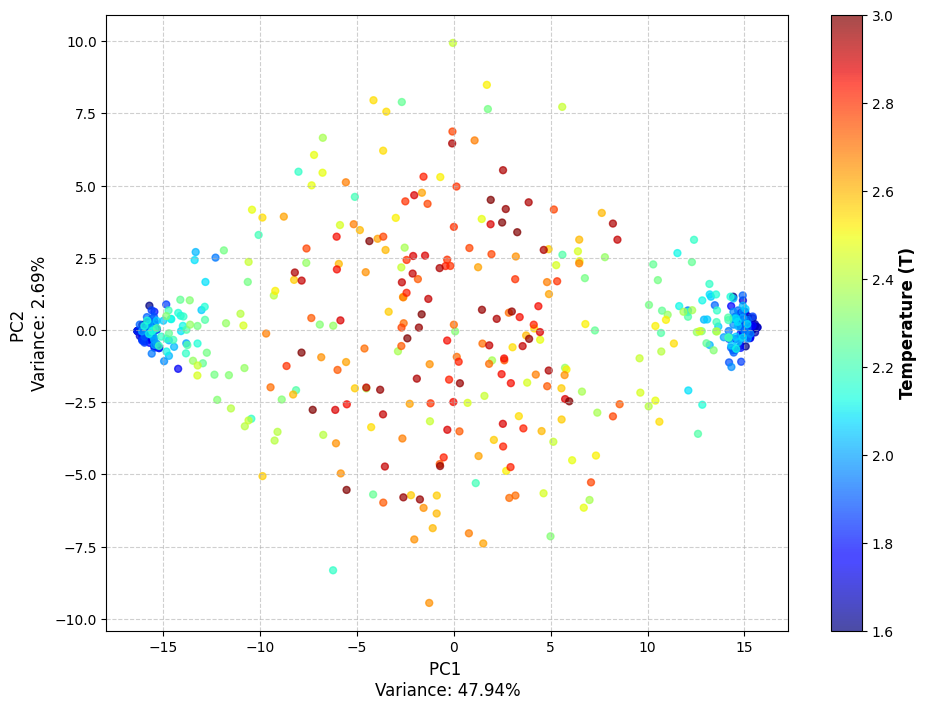

In [50]:
from sklearn.decomposition import PCA

L = 16
temperatures = np.linspace(1.6, 3.0, 50) 
samples_per_temp = 10 

data = []
labels = [] 

print("Generating data ...")
for T in temperatures:
    config = np.random.choice([-1, 1], size=(L, L))
    for _ in range(500): wolff_step(config, T) 
        
    for _ in range(samples_per_temp):
        for _ in range(10): wolff_step(config, T) 
        data.append(config.flatten())
        labels.append(T)

X = np.array(data)
y = np.array(labels)

print("Running PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(11, 8))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='jet', alpha=0.7, s=25)
cbar = plt.colorbar(scatter)
cbar.set_label('Temperature (T)', fontsize=12, weight='bold')

plt.xlabel(f'PC1 \nVariance: {pca.explained_variance_ratio_[0]:.2%}', fontsize=12)
plt.ylabel(f'PC2 \nVariance: {pca.explained_variance_ratio_[1]:.2%}', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()